In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Import Features

In [491]:
filename = 'relevant_features/calculated_features.csv'
# filename = 'relevant_features/calculated_relevantFeatures_2_standardized.csv'

calculated_features = pd.read_csv(filename)
calculated_features

,Unnamed: 0,label,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,...,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98"
0,HF2460_WAV_004cleanforms_0,pah,1.0,0.0,0.0,0.0,-183.975890,84781.420701,0.420031,-0.055841,...,0.835380,0.897645,0.960140,0.0,2.103662,10.429799,5.093067,5.507478,3.835366,5.821447
1,HF2460_WAV_004cleanforms_1,pah,1.0,0.0,0.0,0.0,1209.615040,103855.852708,0.373343,-0.006538,...,0.966968,1.031976,1.097233,0.0,2.024755,10.316037,4.523568,4.470352,3.337763,5.048187
2,HF2460_WAV_004cleanforms_2,pah,1.0,0.0,0.0,0.0,-991.043309,75225.054529,0.341877,-0.027847,...,0.863794,0.932746,1.001987,0.0,1.711830,8.557993,3.412886,3.407924,2.390498,3.596940
3,HF2460_WAV_004cleanforms_3,pah,1.0,0.0,0.0,0.0,-827.258870,80500.033643,0.379951,0.008798,...,0.751749,0.799088,0.846674,0.0,1.915319,9.627887,3.938704,4.512067,2.034263,4.673294
4,HF2460_WAV_004cleanforms_4,pah,1.0,0.0,0.0,0.0,-96.612151,78300.909490,0.393418,0.008863,...,0.749854,0.798459,0.847324,0.0,1.859032,9.424060,3.763617,4.190018,2.295007,4.364772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,HJ7804_WAV_004cleanforms_3,pah,1.0,0.0,0.0,0.0,-631.925895,22016.328911,0.298172,-0.013334,...,1.145910,1.296344,1.447235,0.0,2.311299,9.111141,4.631464,4.693419,3.642318,5.125396
152,HJ7804_WAV_004cleanforms_4,pah,1.0,0.0,0.0,0.0,-724.696024,25433.869756,0.293046,0.000663,...,1.326691,1.498911,1.664190,0.0,2.055139,7.908096,3.667062,3.560607,2.691965,4.275777
153,HJ7804_WAV_004cleanforms_5,pah,1.0,0.0,0.0,0.0,212.845731,25083.371870,0.333735,0.021414,...,0.830129,0.890928,0.952141,0.0,1.549909,7.870705,2.720421,2.372209,1.808354,3.147455
154,HJ7804_WAV_004cleanforms_6,pah,1.0,0.0,0.0,0.0,530.922927,29483.519778,0.330733,0.002580,...,0.808849,0.870629,0.932837,0.0,1.461593,6.722306,2.643589,2.439486,1.859990,2.949034


### Export Summary Statistics (if wanted)

In [9]:
is_export = True
filename = 'feature_statistics.csv'

if is_export:
    calculated_features[[col for col in calculated_features.columns if 'value' in col]].describe().transpose().to_csv(filename)

### Box and Whisker of Selected Feature

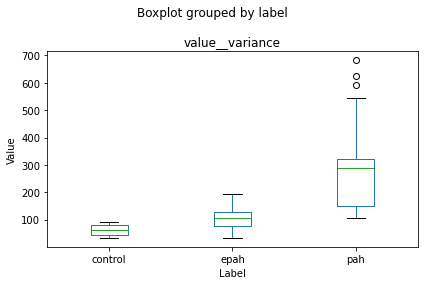

In [421]:
feature = 'value__variance'

calculated_features[['label', feature]].groupby('label').describe()

calculated_features.boxplot(column=feature, by='label', grid=False)
plt.ylabel('Value')
plt.xlabel('Label')
plt.tight_layout()

### One-Way ANOVA

In [422]:
import statsmodels.api as sm
from patsy import dmatrices

from statsmodels.formula.api import ols

model = ols('Q(feature) ~ C(label)', data=calculated_features).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,1.149059e+05,1.0,14.368991,2.156840e-04
C(label),1.196221e+06,2.0,74.793779,2.206926e-23
Residual,1.223510e+06,153.0,NaN,NaN


### Post Hoc Tests

In [423]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(calculated_features[feature], calculated_features['label'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,epah,41.5395,0.0922,-5.1788,88.2578,False
control,pah,205.1943,0.001,157.9948,252.3937,True
epah,pah,163.6548,0.001,125.9231,201.3864,True


### Testing ANOVA Assumptions

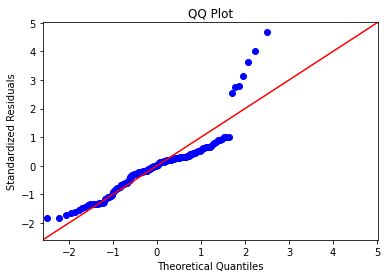

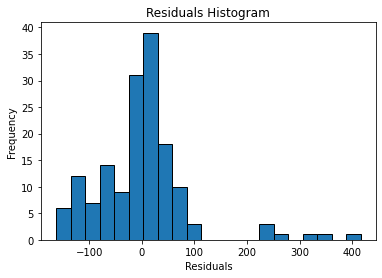

Jarque-Bera:  247.90869945907502
p-value:      1.4699748505000863e-54
Reject:       True
    ==> Residuals ARE NOT normally distributed

Bartlett:     0.8546564256108385
p-value:      0.6522494404740216
Reject:       False
    ==> Sample populations HAVE equal variances



In [424]:
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

influence = model.get_influence()

# QQ Plot
sm.qqplot(influence.resid_studentized_internal, line='45')
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.show()

# Histogram
plt.hist(model.resid, bins='auto', histtype='bar', ec='k')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Jarque-Bera tests the null that data are normally distributed
# aka, if p < 0.05, then reject null --> data are NOT normally distributed
# We want p > 0.05
name = ['Jarque-Bera', 'PValue', 'Skew', 'Kurtosis']
test = jarque_bera(model.resid)
reject = test[1] < 0.05
print(f'Jarque-Bera:  {test[0]}')
print(f'p-value:      {test[1]}')
# print(f'Skew:         {test[2]}')
# print(f'Kurtosis:     {test[3]}')
print(f'Reject:       {reject}')
print('    ==> Residuals ARE ' + ('NOT ' if reject else '') + 'normally distributed')
print()

# Bartlett tests the null that all input samples are from populations with equal variances
# aka, if p < 0.05, then reject null --> samples are NOT from populations with equal variances
# We want p > 0.05
w, pvalue = stats.bartlett(*list(calculated_features[['label', feature]].groupby('label', group_keys=False).groups.values()))
reject = pvalue < 0.05
print(f'Bartlett:     {w}')
print(f'p-value:      {pvalue}')
print(f'Reject:       {reject}')
print('    ==> Sample populations ' + ('DO NOT ' if reject else '') + 'HAVE equal variances')
print()

## Functions: Generate Box Plots & ANOVA

In [579]:
def generate_anova_images(feature, save=True, filename='test.jpg'):
    skip_msg = ''
    if len(calculated_features[feature].unique()) < 3:
        skip_msg = 'Not enough unique values!'
    elif calculated_features[feature].std() < 1e-12:
        skip_msg = 'Not enough variation!'
    
    if len(skip_msg) > 1:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[2].axis('tight')
        axes[2].axis('off')

        table = axes[2].table([['Skipped!', skip_msg]], cellLoc='left', loc='upper center')
        
        # More Table Shenanigans
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        for c in table.get_celld().values():
            c.visible_edges = ''
        
        fig.suptitle(feature)
        
        plt.tight_layout()
    
        if save:
            plt.savefig(filename)
            plt.close()
        return
    
    model = ols('Q(feature) ~ C(label)', data=calculated_features).fit()
    anova_table = sm.stats.anova_lm(model, typ=3)

    tukey = pairwise_tukeyhsd(calculated_features[feature], calculated_features['label'])
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

    influence = model.get_influence()

    # Plot Everything!
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Box Plot
    calculated_features.boxplot(ax=axes[0], column=feature, by='label')
    axes[0].set_title('Box Plot')
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel('')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['bottom'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].xaxis.grid(False)

    # 95% Confidence Intervals
    means = calculated_features[['label', feature]].groupby('label').mean()
    std = calculated_features[['label', feature]].groupby('label').std()
    axes[1].bar(means.index, means.values.T[0], yerr=2*np.concatenate((std.values, std.values), axis=1).T, alpha=0,
                error_kw={
                    'elinewidth':  1,
                    'ecolor':      '#1f77b4',
                    'capsize':     8,
                })
    axes[1].plot(means.index, means.values.T[0], marker='s', linestyle='', color='g')
    axes[1].set_title('95% Confidence interval')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].yaxis.grid(True)
    
    y_min = min([axes[0].get_ylim()[0], min(means.values.T[0])-3*max(std.values)])
    y_max = max([axes[0].get_ylim()[1], max(means.values.T[0])+3*max(std.values)])
    axes[0].set_ylim([y_min, y_max])
    axes[1].set_ylim([y_min, y_max])

    # Table
    axes[2].axis('tight')
    axes[2].axis('off')

    cells = []

    labels = ['control', 'epah', 'pah']
    basic_stats = calculated_features[['label', feature]].groupby('label').describe()
    for label in labels:
        count = basic_stats.loc[label, (feature, 'count')]
        mean = basic_stats.loc[label, (feature, 'mean')]
        std = basic_stats.loc[label, (feature, 'std')]
        cells.append([f'{label} (n={count:.0f}) Mean:', f'{mean:0.3f} ± {std:0.3f}'])

    cells.append(['-'*70, ''])
    cells.append(['One-Way ANOVA', ''])
    cells.append(['F:', f'{anova_table.loc["C(label)", "F"]:0.3f}'])
    cells.append(['p-value:', f'{anova_table.loc["C(label)", "PR(>F)"]:0.3f}'])

    cells.append(['-'*70, ''])
    cells.append(['Post Hoc:', 'Tukey HSD'])
    for index, row in tukey_df.iterrows():
        cells.append([f'{row["group1"]} + {row["group2"]} p-value:', f'{row["p-adj"]}'])

    # Jarque-Bera tests the null that data are normally distributed
    # aka, if p < 0.05, then reject null --> data are NOT normally distributed
    # We want p > 0.05
    test = jarque_bera(model.resid)
    reject = test[1] < 0.05

    cells.append(['-'*70, ''])
    cells.append(['Jarque-Bera:', f'{test[0]:0.3f}'])
    cells.append(['p-value:', f'{test[1]:0.3f}'])
    cells.append(['==> Residuals ARE ' + ('NOT ' if reject else '') + 'normally distributed', ''])

    # Bartlett tests the null that all input samples are from populations with equal variances
    # aka, if p < 0.05, then reject null --> samples are NOT from populations with equal variances
    # We want p > 0.05
    w, pvalue = stats.bartlett(*[calculated_features[calculated_features['label'].eq(label)][feature].to_list() for label in ['control', 'epah', 'pah']])
    reject = pvalue < 0.05

    cells.append(['-'*70, ''])
    cells.append(['Bartlett:', f'{w:0.3f}'])
    cells.append(['p-value:', f'{pvalue:0.3f}'])
    cells.append(['==> Sample populations ' + ('DO NOT ' if reject else '') + 'HAVE equal variances', ''])

    table = axes[2].table(cells, cellLoc='left', loc='upper center')

    # More Table Shenanigans
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    for c in table.get_celld().values():
        c.visible_edges = ''

    fig.suptitle(feature)

    plt.tight_layout()
    
    if save:
        plt.savefig(filename)
        plt.close()

def generate_anova_csv(all_features, save=True, filename='test.csv'):
    df = calculated_features[all_features].describe().transpose()
    df.columns = [f'total__{col}' for col in df.columns.values]
    df.index.names = ['feature']
    
    features_list = []
    for feature in all_features:
        # Get basic statistics for each group
        temp_df = calculated_features[[feature, 'label']].groupby('label').describe().stack().T
        temp_df.columns = ['__'.join(col).strip() for col in temp_df.columns.values]
        temp_df.index.names= ['feature']
        
        features_dict = temp_df.to_dict(orient='records')[0]
        
        features_dict['feature'] = feature
        
        # Skip if data are not well behaved
        skip_msg = ''
        if len(calculated_features[feature].unique()) < 3:
            skip_msg = 'Not enough unique values! '
        elif calculated_features[feature].std() < 1e-12:
            skip_msg = 'Not enough variation! '

        features_dict['anova_notes'] = skip_msg
        if len(skip_msg) > 1:
            features_list.append(features_dict)
            continue
        
        # Calculate ANOVA and Tukey HSD
        model = ols('Q(feature) ~ C(label)', data=calculated_features).fit()
        anova_table = sm.stats.anova_lm(model, typ=3)

        tukey = pairwise_tukeyhsd(calculated_features[feature], calculated_features['label'])
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

        influence = model.get_influence()
        
        features_dict['f-oneway_stat'] = anova_table.loc['C(label)', 'F']
        features_dict['f-oneway_pvalue'] = anova_table.loc['C(label)', 'PR(>F)']

        for index, row in tukey_df.iterrows():
            features_dict[f'tukey-HSD_{row["group1"]}_{row["group2"]}_pvalue'] = row['p-adj']

        # Jarque-Bera tests the null that data are normally distributed
        # aka, if p < 0.05, then reject null --> data are NOT normally distributed
        # We want p > 0.05
        test = jarque_bera(model.resid)

        features_dict['jarque-bera_stat'] = test[0]
        features_dict['jarque-bera_pvalue'] = test[1]

        # Bartlett tests the null that all input samples are from populations with equal variances
        # aka, if p < 0.05, then reject null --> samples are NOT from populations with equal variances
        # We want p > 0.05
        w, pvalue = stats.bartlett(*[calculated_features[calculated_features['label'].eq(label)][feature].to_list() for label in ['control', 'epah', 'pah']])

        features_dict['bartlett_stat'] = w
        features_dict['bartlett_pvalue'] = pvalue
        
        # Notes if Jarque-Bera or Bartlett reject
        test_msg = ''
        if test[1] < 0.05:
            test_msg += 'Non-normal residuals! '
        if pvalue < 0.05:
            test_msg += 'Heteroscedastic samples! '
        
        features_dict['anova_notes'] = test_msg
        
        features_list.append(features_dict)
        
    df = df.merge(pd.DataFrame(features_list), on='feature')
    
    if save:
        df.to_csv(filename, index=False)
    
    return df

### Generate Images w/ Box Plots & ANOVA for all features

In [493]:
features = [col for col in calculated_features.columns if 'value' in col]

for feature in features:
    feature_name_sanitized = feature.replace('\"', '')
    generate_anova_images(feature, save=True, filename=f'features_statistics/ANOVA/{feature_name_sanitized}.jpg')

C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\scipy\stats\morestats.py:2303: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\scipy\stats\morestats.py:2303: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


### Generate CSVs w/ Box Plots & ANOVA for all features

In [582]:
filename = 'relevant_features/calculated_features_standardized.csv'

calculated_features = pd.read_csv(filename)

features = [col for col in calculated_features.columns if 'value' in col]

df = generate_anova_csv(features, filename='features_statistics/anova_statistics_standardized.csv')

C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\scipy\stats\morestats.py:2303: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


In [594]:
# Save only the features that satisfy ANOVA assumptions and were rejected by the testing
df = pd.read_csv('features_statistics/anova_statistics.csv')
df_standardized = pd.read_csv('features_statistics/anova_statistics_standardized.csv')

col_list = ['feature'] + [col for col in df.columns if 'total__' in col or 'control__' in col or 'pah__' in col or 'tukey' in col]

df[(df['anova_notes'].isnull()) &
   (df['f-oneway_pvalue'] < 0.05)][col_list].to_csv('anova_significant_features.csv', index=False)

df_standardized[(df_standardized['anova_notes'].isnull()) &
                (df_standardized['f-oneway_pvalue'] < 0.05)][col_list].to_csv('anova_significant_features_standardized.csv', index=False)